In [1]:
import numpy as np
import matplotlib.pyplot as plt
from random import randint
from scipy import integrate

In [2]:
from bs4 import BeautifulSoup # For HTML parsing
import urllib2 # Website connections
import re # Regular expressions
from time import sleep # To prevent overwhelming the server between connections
from collections import Counter # Keep track of our term counts
#from nltk.corpus import stopwords # Filter out stopwords, such as 'the', 'or', 'and'
import nltk
import pandas as pd # For converting results to a dataframe and bar chart plots
%matplotlib inline

## Now, I'm going to learn  Beautiful Soup:

#### 1. a tag:

In [4]:
soup = BeautifulSoup('<b class="boldest">Extremely bold</b>',"html.parser")
tag = soup.b
type(tag)

bs4.element.Tag

A tag has a name (say, "someTag"). It contains a set of attribute:value(s). The following is an example of the structure of a tag:

$\text{<someTag attr1="value" attr2="value1 value2">  A String  </someTag>}$

In [39]:
print tag.name
print tag["class"]
print tag.attrs

b
['boldest']
{'class': ['boldest']}


i.e. we can use .attrs to show the dictionary of a specified tag (attr, value).

Also, the things within the begin and the end tag (i.e. within $<b>$ and $</b>$) are strings:

In [40]:
print type(tag.string)
print tag.string

<class 'bs4.element.NavigableString'>
Extremely bold


These strings are objects of the type NavigableString. i.e. we can do further actions such as to find its direct parent:

In [77]:
print tag.string.parent                   # a NavigableString obj
print unicode(tag.string.parent)          # a unicode string
print repr(unicode(tag.string.parent))    # a unicode string (in repr(), if the string is "unicode" encoded, it will begin by u')

#check the types of the above stuffs:
print type(tag.string.parent)             
print type(unicode(tag.string.parent))
print type(repr(unicode(tag.string.parent)))

<p class="story">...</p>
<p class="story">...</p>
u'<p class="story">...</p>'
<class 'bs4.element.Tag'>
<type 'unicode'>
<type 'str'>


or find its parent's parent(now we have the easiest situation, i.e. they have only one direct parent):

In [46]:
print tag.string.parent.parent

<body><b class="boldest">Extremely bold</b></body>


The most common multi-valued attribute is class:

In [47]:
css_soup = BeautifulSoup('<p class="body strikeout"></p>')
print css_soup.p['class']
# ["body", "strikeout"]

css_soup = BeautifulSoup('<p class="body strikeout"></p>', "lxml")
print css_soup.p['class']

['body', 'strikeout']
['body', 'strikeout']


on the other hand, id is not a multi-valued attribute:

In [9]:
id_soup = BeautifulSoup('<p id="my id"></p>')
id_soup.p['id']
# 'my id'

'my id'

Now, let's see a slightly complex situation:

In [46]:
html_doc = """
<html><head><title>The Dormouse's story</title></head>
<body>
<p class="title"><b>The Dormouse's story</b></p>

<p class="story">Once upon a time there were three little sisters; and their names were</p>
<a href="http://example.com/elsie" class="sister" id="link1">Elsie</a>,
<a href="http://example.com/lacie" class="sister" id="link2">Lacie</a> and
<a href="http://example.com/tillie" class="sister" id="link3">Tillie</a>;
and they lived at the bottom of a well.</p>

<p class="story">...</p>
"""
soup = BeautifulSoup(html_doc, 'html.parser')

First of all, let's see the prettified structure:

In [47]:
print soup.prettify()

<html>
 <head>
  <title>
   The Dormouse's story
  </title>
 </head>
 <body>
  <p class="title">
   <b>
    The Dormouse's story
   </b>
  </p>
  <p class="story">
   Once upon a time there were three little sisters; and their names were
  </p>
  <a class="sister" href="http://example.com/elsie" id="link1">
   Elsie
  </a>
  ,
  <a class="sister" href="http://example.com/lacie" id="link2">
   Lacie
  </a>
  and
  <a class="sister" href="http://example.com/tillie" id="link3">
   Tillie
  </a>
  ;
and they lived at the bottom of a well.
 </body>
</html>
<p class="story">
 ...
</p>



In [48]:
print soup.p

<p class="title"><b>The Dormouse's story</b></p>


apparently, the above is not what I want. I actually would like to obtain all the tags which is labeled as "p". This can be achieved by taking the advantage of the method "find_all":

In [52]:
for tag in soup.find_all("p"):
    print tag
    print tag.name
    print tag.attrs
    print tag["class"]
    print type(tag["class"][0])
    print tag.string
    print "==================================================================================================="

<p class="title"><b>The Dormouse's story</b></p>
p
{u'class': [u'title']}
[u'title']
<type 'unicode'>
The Dormouse's story
<p class="story">Once upon a time there were three little sisters; and their names were</p>
p
{u'class': [u'story']}
[u'story']
<type 'unicode'>
Once upon a time there were three little sisters; and their names were
<p class="story">...</p>
p
{u'class': [u'story']}
[u'story']
<type 'unicode'>
...


In [81]:
for string in soup.strings:
    print(repr(string))
    print repr(string.encode("ascii"))
    print

u'\n'
'\n'

u"The Dormouse's story"
"The Dormouse's story"

u'\n'
'\n'

u'\n'
'\n'

u"The Dormouse's story"
"The Dormouse's story"

u'\n'
'\n'

u'Once upon a time there were three little sisters; and their names were'
'Once upon a time there were three little sisters; and their names were'

u'\n'
'\n'

u'Elsie'
'Elsie'

u',\n'
',\n'

u'Lacie'
'Lacie'

u' and\n'
' and\n'

u'Tillie'
'Tillie'

u';\nand they lived at the bottom of a well.'
';\nand they lived at the bottom of a well.'

u'\n'
'\n'

u'...'
'...'

u'\n'
'\n'



So many spaces there. The spaces can be removed via stripping the strings:

In [84]:
for string in soup.stripped_strings:
    print(repr(string.encode("ascii")))

"The Dormouse's story"
"The Dormouse's story"
'Once upon a time there were three little sisters; and their names were'
'Elsie'
','
'Lacie'
'and'
'Tillie'
';\nand they lived at the bottom of a well.'
'...'


Well, we could also put all the stripped strings into a list:

In [85]:
[repr(string.encode("ascii")) for string in soup.stripped_strings]

['"The Dormouse\'s story"',
 '"The Dormouse\'s story"',
 "'Once upon a time there were three little sisters; and their names were'",
 "'Elsie'",
 "','",
 "'Lacie'",
 "'and'",
 "'Tillie'",
 "';\\nand they lived at the bottom of a well.'",
 "'...'"]

In [86]:
print soup.prettify()

<html>
 <head>
  <title>
   The Dormouse's story
  </title>
 </head>
 <body>
  <p class="title">
   <b>
    The Dormouse's story
   </b>
  </p>
  <p class="story">
   Once upon a time there were three little sisters; and their names were
  </p>
  <a class="sister" href="http://example.com/elsie" id="link1">
   Elsie
  </a>
  ,
  <a class="sister" href="http://example.com/lacie" id="link2">
   Lacie
  </a>
  and
  <a class="sister" href="http://example.com/tillie" id="link3">
   Tillie
  </a>
  ;
and they lived at the bottom of a well.
 </body>
</html>
<p class="story">
 ...
</p>



In [89]:
link = soup.a
print link
print 
# <a class="sister" href="http://example.com/elsie" id="link1">Elsie</a>
for parent in link.parents:
    if parent is None:
        print(parent)
    else:
        print(parent.name)

<a class="sister" href="http://example.com/elsie" id="link1">Elsie</a>

body
html
[document]


We've successfully found the parent of the specified tag. This can be verified by seeing the structure obtained from the method soup.prettify().

In [90]:
print soup.name

for child in soup.children:
    print child

[document]


<html><head><title>The Dormouse's story</title></head>
<body>
<p class="title"><b>The Dormouse's story</b></p>
<p class="story">Once upon a time there were three little sisters; and their names were</p>
<a class="sister" href="http://example.com/elsie" id="link1">Elsie</a>,
<a class="sister" href="http://example.com/lacie" id="link2">Lacie</a> and
<a class="sister" href="http://example.com/tillie" id="link3">Tillie</a>;
and they lived at the bottom of a well.</body></html>


<p class="story">...</p>




The above result is understandable since from the method soup.prettify() we know already that $<html>$ and $<p>$ are the direct children of the parent $[document]$.

Now, let's see its descendants:

In [63]:
print soup.body.name
print type(soup.body.descendants)

for child in soup.body.descendants:
    print child

body
<type 'generator'>


<p class="title"><b>The Dormouse's story</b></p>
<b>The Dormouse's story</b>
The Dormouse's story


<p class="story">Once upon a time there were three little sisters; and their names were</p>
Once upon a time there were three little sisters; and their names were


<a class="sister" href="http://example.com/elsie" id="link1">Elsie</a>
Elsie
,

<a class="sister" href="http://example.com/lacie" id="link2">Lacie</a>
Lacie
 and

<a class="sister" href="http://example.com/tillie" id="link3">Tillie</a>
Tillie
;
and they lived at the bottom of a well.


idea: to get all the strings of all the "p" tags:

In [62]:
for single_tag in soup.find_all("p"):
    for string in single_tag:
        print string

<b>The Dormouse's story</b>
Once upon a time there were three little sisters; and their names were
...


Well, not sure if this will be useful. Anyway, let's move on first.

I now have the problem about the type "generator". I'd like to understand both the types "generator" and "iterator" in Python better.

In [9]:
a = [1, 2, 3, 4]
b=123
print type(a.__iter__)
print type(a.__init__)
print type(b.__init__)
print type(b.__iter__)

<type 'method-wrapper'>
<type 'method-wrapper'>
<type 'method-wrapper'>


AttributeError: 'int' object has no attribute '__iter__'

>When Python executes the for loop, it first invokes the $__iter__()$ method of the container to get the iterator of the container. It then repeatedly calls the next() method $__next__()$ method in Python 3.x) of the iterator until the iterator raises a StopIteration exception. Once the exception is raised, the for loop ends.

which means that a list is iterable. More details see: http://www.shutupandship.com/2012/01/understanding-python-iterables-and.html

Let's quote the summary from that site (written by Praveen Gollakota):
>If you define a custom container class, think about whether it should also be an iterable. 
It is quite easy to make a class support the iterator protocol. 
Doing so will make the syntax more natural.

If I can't recall what the above summary says or how to make a class iterable in the future, I'll visit that website again.

Now, let's continue. What is a generator in Python?

In [32]:
# Using the generator pattern (an iterable)
class firstn(object):
    def __init__(self, n):
        self.n = n
        self.num, self.nums = 0, []
    def __iter__(self):
        return self
    # Python 3 compatibility
    def __next__(self):                  # Okay, I knew this. In Python3 one should be using __next__.
        return self.next()
    def next(self):
        if self.num < self.n:
            cur, self.num = self.num, self.num+1
            return cur
        else:
            raise StopIteration()

In [33]:
print type(firstn(3))
for j in firstn(3):
    print j
print
a=firstn(3)
for _ in range(3):
    print a.next()

<class '__main__.firstn'>
0
1
2

0
1
2


Well, this I understand. The above is nothing but the concept of the iterator.



> (https://wiki.python.org/moin/Generators)

>Python provides generator functions as a convenient shortcut to building iterators. Lets us rewrite the above iterator as a generator function: 

In [34]:
def firstn(n):
    num = 0
    while num < n:
        yield num
        num += 1

In [38]:
a=firstn(3)
for a in firstn(3):
    print a

0
1
2


I got it. In this way, the iterator can be built easier. That's it. I think 1) the design pattern of the generator is simpler than the design pattern of the iterator. 2) their behave should be the same.

Now, due to the string we have got has a special type (NavigableString), we can find the direct parent of these special strings.

In [48]:
print [soup.find_all("p")[j].string for j in range(3)][1].parent.parent

<body>
<p class="title"><b>The Dormouse's story</b></p>
<p class="story">Once upon a time there were three little sisters; and their names were</p>
<a class="sister" href="http://example.com/elsie" id="link1">Elsie</a>,
<a class="sister" href="http://example.com/lacie" id="link2">Lacie</a> and
<a class="sister" href="http://example.com/tillie" id="link3">Tillie</a>;
and they lived at the bottom of a well.</body>


Now, let's see if we can print out all the strings of the site:

In [67]:
for string in soup.strings:
    print(repr(string))
    print((string))
    print(type(string))
    print"======================================"

u'\n'


<class 'bs4.element.NavigableString'>
u"The Dormouse's story"
The Dormouse's story
<class 'bs4.element.NavigableString'>
u'\n'


<class 'bs4.element.NavigableString'>
u'\n'


<class 'bs4.element.NavigableString'>
u"The Dormouse's story"
The Dormouse's story
<class 'bs4.element.NavigableString'>
u'\n'


<class 'bs4.element.NavigableString'>
u'Once upon a time there were three little sisters; and their names were'
Once upon a time there were three little sisters; and their names were
<class 'bs4.element.NavigableString'>
u'\n'


<class 'bs4.element.NavigableString'>
u'Elsie'
Elsie
<class 'bs4.element.NavigableString'>
u',\n'
,

<class 'bs4.element.NavigableString'>
u'Lacie'
Lacie
<class 'bs4.element.NavigableString'>
u' and\n'
 and

<class 'bs4.element.NavigableString'>
u'Tillie'
Tillie
<class 'bs4.element.NavigableString'>
u';\nand they lived at the bottom of a well.'
;
and they lived at the bottom of a well.
<class 'bs4.element.NavigableString'>
u'\n'


<class 'bs4.element.Navi

or the stripped strings(unnecessary spaces are removed)

In [70]:
for string in soup.stripped_strings:
    print(repr(string))

u"The Dormouse's story"
u"The Dormouse's story"
u'Once upon a time there were three little sisters; and their names were'
u'Elsie'
u','
u'Lacie'
u'and'
u'Tillie'
u';\nand they lived at the bottom of a well.'
u'...'


#### Siblings:

In [72]:
sibling_soup = BeautifulSoup("<a><b>text1</b><c>text2</c></b></a>","lxml")
print(sibling_soup.prettify())

<html>
 <body>
  <a>
   <b>
    text1
   </b>
   <c>
    text2
   </c>
  </a>
 </body>
</html>


In [88]:
print sibling_soup.b.next_sibling
print sibling_soup.b.previous_sibling

<c>text2</c>
None


In [89]:
print sibling_soup.c.next_sibling
print sibling_soup.c.previous_sibling

None
<b>text1</b>


back to the soup example. Let's find the siblings of the tag "a" in an iterating way.

In [93]:
print type(soup.a.next_siblings)

<type 'generator'>


apparently, it is a generator. So, we can do the following:

In [91]:
for sibling in soup.a.next_siblings:
    print(repr(sibling))

u',\n'
<a class="sister" href="http://example.com/lacie" id="link2">Lacie</a>
u' and\n'
<a class="sister" href="http://example.com/tillie" id="link3">Tillie</a>
u';\nand they lived at the bottom of a well.'


In [33]:
site = urllib2.urlopen("https://www.104.com.tw/job/?jobno=4x4f5&jobsource=n104bank1&hotjob_chr=").read()
import html5lib
soup_obj = BeautifulSoup(site, "html5lib")

soup_obj.get_text()

for string in soup_obj.stripped_strings:
    print string

/*<![CDATA[*/
var jlocation=[25.0516953,121.5606501,'台北市松山區南京東路五段99號'];
var jcate = {'資料庫管理人員' : ['https://pda.104.com.tw/my104/assist/analysisdetail?JOBCAT=2007002002', 'https://www.104.com.tw/jobbank/joblist/joblist.cfm?cat=2007002002'],'演算法開發工程師' : ['https://pda.104.com.tw/my104/assist/analysisdetail?JOBCAT=2007001012', 'https://www.104.com.tw/jobbank/joblist/joblist.cfm?cat=2007001012'],'軟體設計工程師' : ['https://pda.104.com.tw/my104/assist/analysisdetail?JOBCAT=2007001004', 'https://www.104.com.tw/jobbank/joblist/joblist.cfm?cat=2007001004']}
var g_baseUrl='/job';
var g_staticUrl='https://static.104.com.tw/104main';
var g_mainUrl='https://www.104.com.tw';
/*]]>*/
IH-數據資料工程師(上班地點:台北市南京東路)_麗寶大數據股份有限公司 - 104人力銀行
IH-數據資料工程師(上班地點:台北市南京東路)
麗寶大數據股份有限公司
本公司其他工作
我要應徵
處理中...
儲存工作
處理中...
6~10人應徵
FB 分享
轉寄
檢舉
工作內容
1. 從大量資料中找出 model/pattern
2. 透過資料驗證 pattern/model
3. 演算法最佳化
4. 效能評估
5. 即時資料分析
6. 自行開發資料測試與驗證程式
7. 閱讀與研究推薦/分析演算法論文
8. 實作推薦/與資料分析演算法
職務類別：
資料庫管理人員
、
演算法開發工程師
、
軟體設計工程師
認識「
」職務
詳細職類分析(工作內容、薪

#### Now, let's try to retreive texts from a site for test:

In [5]:
def text_cleaner(url):

    site = urllib2.urlopen(url).read()                 # read the url link
    soup = BeautifulSoup(site, 'html.parser')          # let our beautiful soup to parse the site

    for script in soup(["script", "style"]):           # Remove these two unnecessary tags: "script" and "style"
        _=script.extract()                       

    stopwords = nltk.corpus.stopwords.words('english') # a list of words which are not important
                                                       # we will ignore these words if they show up in the context
    text=soup.get_text(" ",strip=True)
    text=re.sub(r"[^a-zA-Z.3+]"," ",text)              # preserve . and 3 for "d3.js". Also, preserve "+" for "c++"

    content=[w.strip(".") for w in text.lower().split() if w not in stopwords] # remove any "." if it's contained 
                                                                               # at the begin or the end of the string
    return content

In [73]:
content = text_cleaner('https://www.104.com.tw/job/?jobno=55spt&jobsource=close&hotjob_chr=')
for w in content:
    print w

data
scientist
data
scientist


fb
domain
know
data
driven
data
pipeline
e.g
python
r
sql
nosql
bigquery
yoy
mom
seo
ing
agile
kanban
scrum
data
driven
user
centric

ps
workshop
coder
pm
ux
ui
designer
happy
hour
+
hack
day

3
nlp
deep
learning
script
javascript
node.js

data
scientist
3
ie

corporation
rights
reserved


#### On Indeed.com

In [162]:
content=text_cleaner("http://www.indeed.com/viewjob?jk=5505e59f8e5a32a4&q=%22data+scientist%22&tk=19ftfgsmj19ti0l3&from=web&advn=1855944161169178&sjdu=QwrRXKrqZ3CNX5W-O9jEvWC1RT2wMYkGnZrqGdrncbKqQ7uwTLXzT1_ME9WQ4M-7om7mrHAlvyJT8cA_14IV5w&pub=pub-indeed")
for w in content:
    print w

data
scientist
job
indeed
seattle
wa
indeed.com
skip
job
description
search
close
find
jobs
find
resumes
employers
post
job
upload
resume
sign
advanced
job
search
job
title
keywords
company
city
state
zip
data
scientist
indeed
33
reviews
seattle
wa
job
posting
longer
available
indeed
find
similar
jobs
data
scientist
jobs
indeed
jobs
data
scientist
works
data
scientist
indeed
role
follow
data
analyze
visualize
model
job
search
related
data
build
implement
machine
learning
models
make
timely
decisions
access
unparalleled
resources
within
indeed
grow
develop
personally
professionally
looking
mixture
statistician
scientist
machine
learning
expert
engineer
someone
passion
building
improving
internet
scale
products
informed
data
ideal
candidate
understands
human
behavior
knows
look
data
responsibilities
drive
roadmap
proactively
identifying
opportunities
data
evaluate
big
picture
solve
business
problems
rather
focusing
metrics
alone
create
great
visualizations
looking
someone
small
data
mode

In [24]:
final_site_list = ['http://www.indeed.com/jobs?q=%22','data+scientist', '%22&l=', "New+York",
                    '%2C+', "NY"]
final_site = ''.join(final_site_list)
base_url = 'http://www.indeed.com'
print final_site
html = urllib2.urlopen(final_site).read()
soup = BeautifulSoup(html,"lxml")

print soup.find(id = 'searchCount')
num_jobs_area=soup.find(id = 'searchCount').string

job_numbers = re.findall('\d+', num_jobs_area)
if len(job_numbers) > 3: # Have a total number of jobs greater than 1000
    total_num_jobs = (int(job_numbers[2])*1000) + int(job_numbers[3])
else:
    total_num_jobs = int(job_numbers[2])
    
num_pages = total_num_jobs/10 # This will be how we know the number of times we need to iterate over each new
                                      # search result page
print "num_pages=",num_pages

job_descriptions = [] # Store all our descriptions in this list
#for i in range(num_pages): # Loop through all of our search result pages
for i in (0,): # Loop through all of our search result pages
    start_num = str(i*10) # Assign the multiplier of 10 to view the pages we want
    current_page = ''.join([final_site, '&start=', start_num])
    print 'Getting page', i,"start_num=",start_num
    print current_page
    html_page = urllib2.urlopen(current_page).read() # Get the page
    page_obj = BeautifulSoup(html_page,"lxml") # Locate all of the job links within the <body> area
    #for script in page_obj(["style","script"]):
    #    _=script.extract()
    job_link_area=page_obj
    #job_link_area = page_obj.find(id = 'resultsCol') # The center column on the page where the job postings exist
    #print len(page_obj.find_all(id="resultsCol"))

    #for link in job_link_area.find_all('a'):
    #    try:
    #        print link['href']     # link["href"] might throw an exception if it did not find the attribute "href". Use link.get("href") instead
    #    except:
    #        print "error. href is not contained"
    #job_URLs=[str(link.get('href')) for link in job_link_area.find_all('a')]
    
    #for link in page_obj.find_all('a'):
    #    print link.attrs
    
    print job_URLs,len(job_URLs),type(job_URLs)
    ##print "=================================="
    #job_URLs=filter(lambda x:'clk?jk' in x, job_URLs)
    #print job_URLs,len(job_URLs),type(job_URLs)
    #for URL in job_URLs:
    #    final_description = text_cleaner(URL)
    #    if final_description: # So that we only append when the website was accessed correctly
    #        job_descriptions.append(final_description)
    #    sleep(1) # So that we don't be jerks. If you have a very fast internet connection you could hit the server a lot! 
        
    #print 'Done with collecting the job postings!'    
    #print 'There were', len(job_descriptions), 'jobs successfully found.'

http://www.indeed.com/jobs?q=%22data+scientist%22&l=New+York%2C+NY
<div id="searchCount">Jobs 1 to 10 of 379</div>
num_pages= 37
Getting page 0 start_num= 0
http://www.indeed.com/jobs?q=%22data+scientist%22&l=New+York%2C+NY&start=0
{'href': '#jobPostingsAnchor', 'id': 'skipToJobs', 'class': ['accessibilityMenu']}
{'href': '#what', 'id': 'skipToSearch', 'class': ['accessibilityMenu']}
{'id': 'accessibilityClose'}
{'id': 'jobsLink', 'href': '/', 'class': ['selected'], 'title': 'Jobs'}
{'href': '/resumes?isid=find-resumes&ikw=SERPtop&co=US&hl=en', 'id': 'rezLink'}
{'href': '/hire?hl=en&cc=US', 'id': 'empLink', 'onclick': "if ( this.href.match('&isid=employerlink-US-control&ikw=SERPtop') == null ) { this.href += '&isid=employerlink-US-control&ikw=SERPtop' };"}
{'href': '/promo/resume', 'onclick': "window.location=this.href + '?from=nav&subfrom=rezprmstd&trk.origin=jobsearch&trk.variant=rezprmstd&trk.tk=1b0aoqj9ab9a2end'; return false;"}
{'href': 'http://www.indeed.com/account/login?dest=%2

In [49]:
def skills_info(city = None, state = None):

    city_title = city
    if city is None:
        city_title = 'Nationwide'
        
    print 'There were', total_num_jobs, 'jobs found,', city_title # Display how many jobs were found
    
    num_pages = total_num_jobs/10 # This will be how we know the number of times we need to iterate over each new
                                      # search result page
    job_descriptions = [] # Store all our descriptions in this list
    #for i in xrange(1,num_pages+1): # Loop through all of our search result pages
    for i in (0,): # Loop through all of our search result pages
        print 'Getting page', i
        start_num = str(i*10) # Assign the multiplier of 10 to view the pages we want
        current_page = ''.join([final_site, '&start=', start_num])
        # Now that we can view the correct 10 job returns, start collecting the text samples from each  
        html_page = urllib2.urlopen(current_page).read() # Get the page
        page_obj = BeautifulSoup(html_page) # Locate all of the job links
        job_link_area = page_obj.find(id = 'resultsCol') # The center column on the page where the job postings exist
        job_URLS = [base_url + str(link.get('href') ) for link in job_link_area.find_all('a')] # Get the URLS for the jobs ?????
        job_URLS = filter(lambda x:'clk' in x, job_URLS) # Now get just the job related URLS

        print job_URLs,len(job_URLs)
        
        for j in xrange(0,len(job_URLS)):
            final_description = text_cleaner(job_URLS[j])
            if final_description: # So that we only append when the website was accessed correctly
                job_descriptions.append(final_description)
            sleep(1) # So that we don't be jerks. If you have a very fast internet connection you could hit the server a lot! 
        
    print 'Done with collecting the job postings!'    
    print 'There were', len(job_descriptions), 'jobs successfully found.'
    
    
    doc_frequency = Counter() # This will create a full counter of our terms. 
    [doc_frequency.update(item) for item in job_descriptions] # List comp
    
    # Now we can just look at our final dict list inside doc_frequency
    
    # Obtain our key terms and store them in a dict. These are the key data science skills we are looking for
    
    prog_lang_dict = Counter({'R':doc_frequency['r'], 'Python':doc_frequency['python'],
                    'Java':doc_frequency['java'], 'C++':doc_frequency['c++'],
                    'Ruby':doc_frequency['ruby'],
                    'Perl':doc_frequency['perl'], 'Matlab':doc_frequency['matlab'],
                    'JavaScript':doc_frequency['javascript'], 'Scala': doc_frequency['scala']})
                      
    analysis_tool_dict = Counter({'Excel':doc_frequency['excel'],  'Tableau':doc_frequency['tableau'],
                        'D3.js':doc_frequency['d3.js'], 'SAS':doc_frequency['sas'],
                        'SPSS':doc_frequency['spss'], 'D3':doc_frequency['d3']})  

    hadoop_dict = Counter({'Hadoop':doc_frequency['hadoop'], 'MapReduce':doc_frequency['mapreduce'],
                'Spark':doc_frequency['spark'], 'Pig':doc_frequency['pig'],
                'Hive':doc_frequency['hive'], 'Shark':doc_frequency['shark'],
                'Oozie':doc_frequency['oozie'], 'ZooKeeper':doc_frequency['zookeeper'],
                'Flume':doc_frequency['flume'], 'Mahout':doc_frequency['mahout']})
                
    database_dict = Counter({'SQL':doc_frequency['sql'], 'NoSQL':doc_frequency['nosql'],
                    'HBase':doc_frequency['hbase'], 'Cassandra':doc_frequency['cassandra'],
                    'MongoDB':doc_frequency['mongodb']})
                     
               
    overall_total_skills = prog_lang_dict + analysis_tool_dict + hadoop_dict + database_dict # Combine our Counter objects
    
        
    
    final_frame = pd.DataFrame(overall_total_skills.items(), columns = ['Term', 'NumPostings']) # Convert these terms to a 
                                                                                                # dataframe 
    
    # Change the values to reflect a percentage of the postings 
    
    final_frame.NumPostings = (final_frame.NumPostings)*100/len(job_descriptions) # Gives percentage of job postings 
                                                                                    #  having that term 
    # Sort the data for plotting purposes
    
    final_frame.sort(columns = 'NumPostings', ascending = False, inplace = True)

    # Get it ready for a bar plot
        
    final_plot = final_frame.plot(x = 'Term', kind = 'bar', legend = None, 
                            title = 'Percentage of Data Scientist Job Ads with a Key Skill, ' + city_title)
        
    final_plot.set_ylabel('Percentage Appearing in Job Ads')
    fig = final_plot.get_figure() # Have to convert the pandas plot object to a matplotlib object
        
        
    return fig, final_frame # End of the function

There were 379 jobs found, New York
Getting page 0
['/rc/clk?jk=902c2bf4a0198c35&fccid=0c39fb2c91742dcf', '/rc/clk?jk=c4cb134c96f20a1e&fccid=9a92a4bf81326e1e', '/rc/clk?jk=7e99fe67769abbe7&fccid=fe404d18bb9eef1e', '/rc/clk?jk=f5e03cefdb936a0f&fccid=086cb533b5438773', '/rc/clk?jk=323a0a97aeda1bba&fccid=0c39fb2c91742dcf', '/rc/clk?jk=100d3487f0da530f&fccid=0c39fb2c91742dcf', '/rc/clk?jk=874f75d67840406c&fccid=2c23f29fcd5c78da', '/rc/clk?jk=0fceb1bd7c3159dd&fccid=75dddf0a132694ba', '/rc/clk?jk=dfdb1b64f1d8839e&fccid=48638adc95945cc6'] 9
Done with collecting the job postings!
There were 9 jobs successfully found.


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:77: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


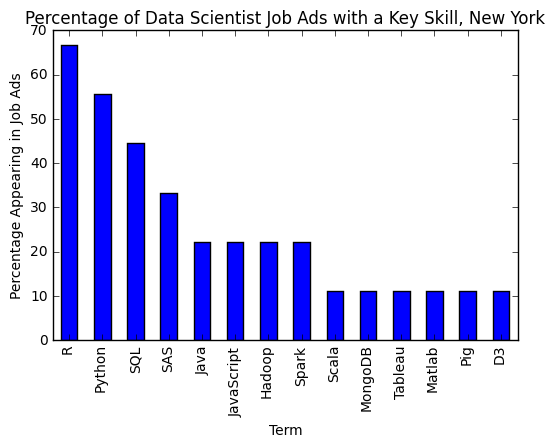

In [50]:
seattle_info = skills_info(city = 'New York', state = 'NY') 

#### the "get_text" method from Beautifulsoup:

In [15]:
soup.get_text("|",strip=True)

u"Data Scientist job - Indeed - Seattle, WA | Indeed.com|Skip to|Job Description|,|Search|Close|Find Jobs|Find Resumes|Employers / Post Job|Upload your resume|Sign in|:|What|Where|Advanced Job Search|job title, keywords or company|city, state, or zip|Data Scientist|Indeed|133 reviews|-|Seattle, WA|This job posting is no longer available on Indeed.|Find similar jobs:|Data Scientist jobs|-|Indeed jobs|How A Data Scientist Works|As a Data Scientist at Indeed your role is to follow the data. Analyze, visualize, and model job search related data. You will build and implement machine learning models to make timely decisions. You will have access to unparalleled resources within Indeed to grow and develop both personally and professionally.|We are looking for a mixture between a statistician, scientist, machine learning expert and engineer: someone who has passion for building and improving Internet-scale products informed by data. The ideal candidate understands human behavior and knows what

#### get to know the Python built-in methods "strip", "splitlines" and "split":

In [102]:
# splitlines:
# (code example from "https://www.tutorialspoint.com/python/string_splitlines.htm)
    
str = "Line1-a b c d e f\nLine2- a b c\n\nLine4- a b c d";
print str.splitlines( )            # the line will break into lines according to the line break \n
print str.splitlines(1)            # line breaks will be included within the splitted string

# strip: 
# (code example from "https://www.tutorialspoint.com/python/string_strip.htm")


print repr("0000000this is string example....\nwow!!!0000000".strip('0'))       # the chars"0" at the both ends 
                                                                                #  of the string will be removed.
print repr("    0000000this is string example....\nwow!!!0000000    ".strip())  # the empty spaces will be removed.

print '1,,2'.split(',')
print '1,,2  345'.split()

['Line1-a b c d e f', 'Line2- a b c', '', 'Line4- a b c d']
['Line1-a b c d e f\n', 'Line2- a b c\n', '\n', 'Line4- a b c d']
'this is string example....\nwow!!!'
'0000000this is string example....\nwow!!!0000000'
['1', '', '2']
['1,,2', '345']


#### understand the regular expression in Python (re.match, re.sub, re.findall):

(https://www.tutorialspoint.com/python/python_reg_expressions.htm)

In [161]:
print "-----------------------------------"
print "tests of 're.match':"
print "-----------------------------------"

m=re.match(r'(bcd){2}',"bcdbcd")
print "re:(bcd){2} string: bcdbcd","match:",repr(m.group())

m=re.match(r'[a-zA-Z][3]{2}',"a33")
print "re:[a-zA-Z][3]{2} string: a33","match:",repr(m.group())

m=re.match(r'[a-zA-Z].+3',"f42312d")
print repr(m.group())
print "re:[a-zA-Z].+3 string: f42312d","match:",repr(m.group())

m = re.match(r"(\d+b)(\d{3})", "24b1632")
print "re:(\d+b)(\d{3}) string: 24b1632","match:",repr(m.group())
print "m.groups():",m.groups() # according to the parenthesis in re, the string will be split into different groups.

print "-----------------------------------"
print "tests of 're.match' with try&catch:"
print "-----------------------------------"

try:
    m=re.match(r'(d3.js)',">")
    print repr(m.group())
except AttributeError:
    print "the re and the string does not match!"
except Exception:   # catch Exception if AttributeError is not the cause
    print "what's happening there?"

try:
    m=re.match(r'(d3.js)',">","123454321")
    print repr(m.group())
except AttributeError:
    print "the re and the string does not match!"
except Exception:   # catch Exception if AttributeError is not the cause
    print "Oops, something wrong!"

print "-----------------------------------"
print "tests of 're.sub':"
print "-----------------------------------"

print "re:\d{2}.* string: 11 2 3 123 abc cde replacement: 00","\nresult:",re.sub(r"\d{2}.*","00", "11 2 3 123 abc cde\n")
print "re:\d{2} string: 11 2 3 123 abc cde replacement: 00","\nresult:",re.sub(r"\d{2}","00", "11 2 3 123 abc cde\n")

# the following line will remove any element of the string 
# which is not within this list: [any alphabets(case irrelevant), ., 3, +]
print "re:[^a-zA-Z.3+] string: #c--d++e**1234.5 replacement: '' ","\nresult:",re.sub(r'[^a-zA-Z.3+]',"", "#c--d++e**1234.5\n")

print "-----------------------------------"
print "tests of 're.findall':"
print "-----------------------------------"

print repr(re.findall(r'\d+',"Jobs 1 to 10 of 382"))

-----------------------------------
tests of 're.match':
-----------------------------------
re:(bcd){2} string: bcdbcd match: 'bcdbcd'
re:[a-zA-Z][3]{2} string: a33 match: 'a33'
'f423'
re:[a-zA-Z].+3 string: f42312d match: 'f423'
re:(\d+b)(\d{3}) string: 24b1632 match: '24b163'
m.groups(): ('24b', '163')
-----------------------------------
tests of 're.match' with try&catch:
-----------------------------------
the re and the string does not match!
Oops, something wrong!
-----------------------------------
tests of 're.sub':
-----------------------------------
re:\d{2}.* string: 11 2 3 123 abc cde replacement: 00 
result: 00

re:\d{2} string: 11 2 3 123 abc cde replacement: 00 
result: 00 2 3 003 abc cde

re:[^a-zA-Z.3+] string: #c--d++e**1234.5 replacement: ''  
result: cd++e3.
-----------------------------------
tests of 're.findall':
-----------------------------------
['1', '10', '382']


#### recall:lambda function (http://www.secnetix.de/olli/Python/lambda_functions.hawk)

In [41]:
foo = [2, 18, 9, 22, 17, 24, 8, 12, 27]

print filter(lambda x: x % 3 == 0, foo)    # from python official doc:
                                           # filter(function, iterable)
                                           # is equivalent to [item for item in iterable if function(item)]
print map(lambda x: x * 2 + 10, foo)
print reduce(lambda x, y: x + y, foo)
print sum(foo)

[18, 9, 24, 12, 27]
[14, 46, 28, 54, 44, 58, 26, 34, 64]
139
139


In [142]:
def text_cleaner(website):
    '''
    This function just cleans up the raw html so that I can look at it.
    Inputs: a URL to investigate
    Outputs: Cleaned text only
    '''
    try:
        site = urllib2.urlopen(website).read() # Connect to the job posting
    except: 
        return            # Need this in case the website isn't there anymore or some other weird connection problem 
    
    soup_obj = BeautifulSoup(site, "lxml")     # Get the html from the site
    
    for script in soup_obj(["script", "style"]):
        script.extract()                       # Remove these two elements from the BS4 object
    
    text = soup_obj.get_text() # Get the text from this
    lines = (line.strip() for line in text.splitlines()) # break into lines
    chunks = (phrase.strip() for line in lines for phrase in line.split("  ")) # break multi-headlines into a line each
    
    def chunk_space(chunk):
        chunk_out = chunk + ' ' # Need to fix spacing issue
        return chunk_out  
        
    
    text = ''.join(chunk_space(chunk) for chunk in chunks if chunk).encode('utf-8') # Get rid of all blank lines and ends of line
        
        
    # Now clean out all of the unicode junk (this line works great!!!)
        
    try:
        text = text.decode('unicode_escape').encode('ascii', 'ignore') # Need this as some websites aren't formatted
    except:                                                            # in a way that this works, can occasionally throw
        return                                                         # an exception
               
    #text = re.sub("[^a-zA-Z.+3]"," ", text)    # Now get rid of any terms that aren't words (include 3 for d3.js)
                                                # Also include + for C++
       
    text = text.lower().split()  # Go to lower case and split them apart

    #stop_words = set(stopwords.words("english")) # Filter out any stop words
    #text = [w for w in text if not w in stop_words]

    text = list(set(text)) # Last, just get the set of these. Ignore counts (we are just looking at whether a term existed
                            # or not on the website)        
    return text

#### the use of the built-in functions "split" and "join":

In [78]:
a = "Free your mind."
b = "Welcome to the desert... of the real."
c = "What is real? How do you define real?"
 
print(a)
print(a.split())
print
 
print(b)
print(b.split("o"))
print
 
print(c)
print(c.split(" ", 4))
print

print '+'.join("abc")
print '+'.join(["a","b","c"])

Free your mind.
['Free', 'your', 'mind.']

Welcome to the desert... of the real.
['Welc', 'me t', ' the desert... ', 'f the real.']

What is real? How do you define real?
['What', 'is', 'real?', 'How', 'do you define real?']

a+b+c
a+b+c


Beautiful soup

https://www.crummy.com/software/BeautifulSoup/bs4/doc/

In [3]:
html_doc = """
<html><head><title>The Dormouse's story</title></head>
<body>
<p class="title"><b>The Dormouse's story</b></p>

<p class="story">Once upon a time there were three little sisters; and their names were
<a href="http://example.com/elsie" class="sister" id="link1">Elsie</a>,
<a href="http://example.com/lacie" class="sister" id="link2">Lacie</a> and
<a href="http://example.com/tillie" class="sister" id="link3">Tillie</a>;
and they lived at the bottom of a well.</p>

<p class="story">...</p>
"""

In [14]:
from bs4 import BeautifulSoup
soup = BeautifulSoup(html_doc, 'html.parser')

In [16]:
print soup.find_all("p")[0]
print soup.find_all("p")[0].get("class")

<p class="title"><b>The Dormouse's story</b></p>
[u'title']


In [5]:
print soup.find_all('a')

[<a class="sister" href="http://example.com/elsie" id="link1">Elsie</a>, <a class="sister" href="http://example.com/lacie" id="link2">Lacie</a>, <a class="sister" href="http://example.com/tillie" id="link3">Tillie</a>]


In [32]:
for link in soup.find_all('a'):
    print type(link)
    print(link.get('href'))

<class 'bs4.element.Tag'>
http://example.com/elsie
<class 'bs4.element.Tag'>
http://example.com/lacie
<class 'bs4.element.Tag'>
http://example.com/tillie


In [8]:
def skills_info(city = None, state = None):
    '''
    This function will take a desired city/state and look for all new job postings
    on Indeed.com. It will crawl all of the job postings and keep track of how many
    use a preset list of typical data science skills. The final percentage for each skill
    is then displayed at the end of the collation. 
        
    Inputs: The location's city and state. These are optional. If no city/state is input, 
    the function will assume a national search (this can take a while!!!).
    Input the city/state as strings, such as skills_info('Chicago', 'IL').
    Use a two letter abbreviation for the state.
    
    Output: A bar chart showing the most commonly desired skills in the job market for 
    a data scientist. 
    '''
        
    final_job = 'data+scientist' # searching for data scientist exact fit("data scientist" on Indeed search)
    
    # Make sure the city specified works properly if it has more than one word (such as San Francisco)
    if city is not None:
        final_city = city.split() 
        final_city = '+'.join(word for word in final_city)
        final_site_list = ['http://www.indeed.com/jobs?q=%22', final_job, '%22&l=', final_city,
                    '%2C+', state] # Join all of our strings together so that indeed will search correctly
    else:
        final_site_list = ['http://www.indeed.com/jobs?q="', final_job, '"']

    final_site = ''.join(final_site_list) # Merge the html address together into one string

    
    base_url = 'http://www.indeed.com'
    
    
    try:
        html = urllib2.urlopen(final_site).read() # Open up the front page of our search first
    except:
        'That city/state combination did not have any jobs. Exiting . . .' # In case the city is invalid
        return
    soup = BeautifulSoup(html) # Get the html from the first page
    
    # Now find out how many jobs there were
    
    num_jobs_area = soup.find(id = 'searchCount').string.encode('utf-8') # Now extract the total number of jobs found
                                                                         # The 'searchCount' object has this
    
    job_numbers = re.findall('\d+', num_jobs_area) # Extract the total jobs found from the search result
    
    
    if len(job_numbers) > 3: # Have a total number of jobs greater than 1000
        total_num_jobs = (int(job_numbers[2])*1000) + int(job_numbers[3])
    else:
        total_num_jobs = int(job_numbers[2]) 
    
    city_title = city
    if city is None:
        city_title = 'Nationwide'
        
    print 'There were', total_num_jobs, 'jobs found,', city_title # Display how many jobs were found
    
    num_pages = total_num_jobs/10 # This will be how we know the number of times we need to iterate over each new
                                      # search result page
    job_descriptions = [] # Store all our descriptions in this list
    
    for i in xrange(1,num_pages+1): # Loop through all of our search result pages
        print 'Getting page', i
        start_num = str(i*10) # Assign the multiplier of 10 to view the pages we want
        current_page = ''.join([final_site, '&start=', start_num])
        # Now that we can view the correct 10 job returns, start collecting the text samples from each
            
        html_page = urllib2.urlopen(current_page).read() # Get the page
            
        page_obj = BeautifulSoup(html_page) # Locate all of the job links
        job_link_area = page_obj.find(id = 'resultsCol') # The center column on the page where the job postings exist
            
        job_URLS = [base_url + str(link.get('href') ) for link in job_link_area.find_all('a')] # Get the URLS for the jobs ?????
            
        job_URLS = filter(lambda x:'clk' in x, job_URLS) # Now get just the job related URLS
            
        
        for j in xrange(0,len(job_URLS)):
            final_description = text_cleaner(job_URLS[j])
            if final_description: # So that we only append when the website was accessed correctly
                job_descriptions.append(final_description)
            sleep(1) # So that we don't be jerks. If you have a very fast internet connection you could hit the server a lot! 
        
    print 'Done with collecting the job postings!'    
    print 'There were', len(job_descriptions), 'jobs successfully found.'
    
    
    doc_frequency = Counter() # This will create a full counter of our terms. 
    [doc_frequency.update(item) for item in job_descriptions] # List comp
    
    # Now we can just look at our final dict list inside doc_frequency
    
    # Obtain our key terms and store them in a dict. These are the key data science skills we are looking for
    
    prog_lang_dict = Counter({'R':doc_frequency['r'], 'Python':doc_frequency['python'],
                    'Java':doc_frequency['java'], 'C++':doc_frequency['c++'],
                    'Ruby':doc_frequency['ruby'],
                    'Perl':doc_frequency['perl'], 'Matlab':doc_frequency['matlab'],
                    'JavaScript':doc_frequency['javascript'], 'Scala': doc_frequency['scala']})
                      
    analysis_tool_dict = Counter({'Excel':doc_frequency['excel'],  'Tableau':doc_frequency['tableau'],
                        'D3.js':doc_frequency['d3.js'], 'SAS':doc_frequency['sas'],
                        'SPSS':doc_frequency['spss'], 'D3':doc_frequency['d3']})  

    hadoop_dict = Counter({'Hadoop':doc_frequency['hadoop'], 'MapReduce':doc_frequency['mapreduce'],
                'Spark':doc_frequency['spark'], 'Pig':doc_frequency['pig'],
                'Hive':doc_frequency['hive'], 'Shark':doc_frequency['shark'],
                'Oozie':doc_frequency['oozie'], 'ZooKeeper':doc_frequency['zookeeper'],
                'Flume':doc_frequency['flume'], 'Mahout':doc_frequency['mahout']})
                
    database_dict = Counter({'SQL':doc_frequency['sql'], 'NoSQL':doc_frequency['nosql'],
                    'HBase':doc_frequency['hbase'], 'Cassandra':doc_frequency['cassandra'],
                    'MongoDB':doc_frequency['mongodb']})
                     
               
    overall_total_skills = prog_lang_dict + analysis_tool_dict + hadoop_dict + database_dict # Combine our Counter objects
    
        
    
    final_frame = pd.DataFrame(overall_total_skills.items(), columns = ['Term', 'NumPostings']) # Convert these terms to a 
                                                                                                # dataframe 
    
    # Change the values to reflect a percentage of the postings 
    
    final_frame.NumPostings = (final_frame.NumPostings)*100/len(job_descriptions) # Gives percentage of job postings 
                                                                                    #  having that term 
    
    # Sort the data for plotting purposes
    
    final_frame.sort(columns = 'NumPostings', ascending = False, inplace = True)

    # Get it ready for a bar plot
        
    final_plot = final_frame.plot(x = 'Term', kind = 'bar', legend = None, 
                            title = 'Percentage of Data Scientist Job Ads with a Key Skill, ' + city_title)
        
    final_plot.set_ylabel('Percentage Appearing in Job Ads')
    fig = final_plot.get_figure() # Have to convert the pandas plot object to a matplotlib object
        
        
    return fig, final_frame # End of the function

There were 218 jobs found, Seattle
Getting page 1
Getting page 2
Getting page 3
Getting page 4
Getting page 5
Getting page 6
Getting page 7
Getting page 8
Getting page 9
Getting page 10
Getting page 11
Getting page 12
Getting page 13
Getting page 14
Getting page 15
Getting page 16
Getting page 17
Getting page 18
Getting page 19
Getting page 20
Getting page 21
Done with collecting the job postings!
There were 150 jobs successfully found.


C:\Users\Student\Anaconda2\lib\site-packages\ipykernel\__main__.py:132: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


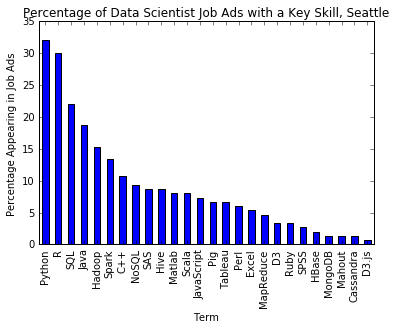

In [9]:
seattle_info = skills_info(city = 'Seattle', state = 'WA') 

There were 342 jobs found, San Francisco
Getting page 1
Getting page 2
Getting page 3
Getting page 4
Getting page 5
Getting page 6
Getting page 7
Getting page 8
Getting page 9
Getting page 10
Getting page 11
Getting page 12
Getting page 13
Getting page 14
Getting page 15
Getting page 16
Getting page 17
Getting page 18
Getting page 19
Getting page 20
Getting page 21
Getting page 22
Getting page 23
Getting page 24
Getting page 25
Getting page 26
Getting page 27
Getting page 28
Getting page 29
Getting page 30
Getting page 31
Getting page 32
Getting page 33
Getting page 34
Done with collecting the job postings!
There were 227 jobs successfully found.


C:\Users\Student\Anaconda2\lib\site-packages\ipykernel\__main__.py:132: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


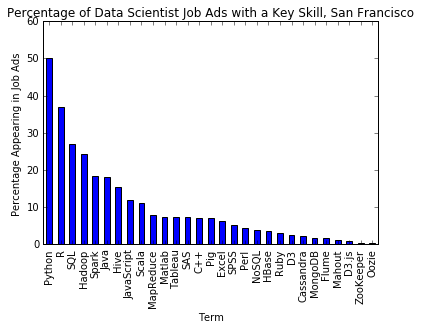

In [10]:
sf_info = skills_info(city = 'San Francisco', state = 'CA') 

There were 369 jobs found, New York
Getting page 1
Getting page 2
Getting page 3
Getting page 4
Getting page 5
Getting page 6
Getting page 7
Getting page 8
Getting page 9
Getting page 10
Getting page 11
Getting page 12
Getting page 13
Getting page 14
Getting page 15
Getting page 16
Getting page 17
Getting page 18
Getting page 19
Getting page 20
Getting page 21
Getting page 22
Getting page 23
Getting page 24
Getting page 25
Getting page 26
Getting page 27
Getting page 28
Getting page 29
Getting page 30
Getting page 31
Getting page 32
Getting page 33
Getting page 34
Getting page 35
Getting page 36
Done with collecting the job postings!
There were 287 jobs successfully found.


C:\Users\Student\Anaconda2\lib\site-packages\ipykernel\__main__.py:132: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


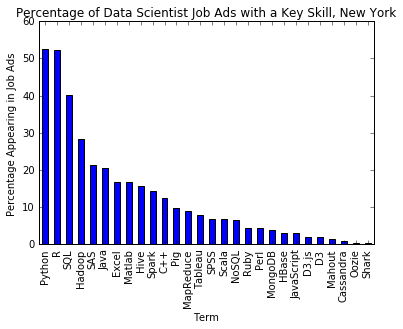

In [12]:
sf_info = skills_info(city = 'New York', state = 'NY') 

In [ ]:
hadoop_dict = Counter({'Hadoop':doc_frequency['hadoop'], 'MapReduce':doc_frequency['mapreduce'],
        'Spark':doc_frequency['spark'], 'Pig':doc_frequency['pig'],
        'Hive':doc_frequency['hive'], 'Shark':doc_frequency['shark'],
        'Oozie':doc_frequency['oozie'], 'ZooKeeper':doc_frequency['zookeeper'],
        'Flume':doc_frequency['flume'], 'Mahout':doc_frequency['mahout']})

In [23]:
sf_info = skills_info() 

There were 3167 jobs found, Nationwide
Getting page 1
Getting page 2
Getting page 3
Getting page 4
Getting page 5


KeyboardInterrupt: 

----

http://wiki.jikexueyuan.com/project/python-crawler-guide/beautiful-soup.html
    
http://stackoverflow.com/questions/27346976/beautifulsoup-find-all-does-not-find-all